# Integer Linear Programming

## Introduction

In Integer Linear Programming (ILP), we seek to find a vector of integer numbers that maximizes (or minimizes) a linear cost function under a set of linear equality or inequality constraints [[1]](#ILP). In other words, it is an optimization problem where the cost function to be optimized and all the constraints are linear and the decision variables are integer.



## Mathematical Formulation
The ILP problem can be formulated as follows:

Given an $n$-dimensional vector $\vec{c} = (c_1, c_2, \ldots, c_n)$, an $m \times n$ matrix $A = (a_{ij})$ with $i=1,\ldots,m$ and $j=1,\ldots,n$, and an $m$-dimensional vector $\vec{b} = (b_1, b_2, \ldots, b_m)$, find an $n$-dimensional vector $\vec{x} = (x_1, x_2, \ldots, x_n)$ with integer entries that maximizes (or minimizes) the cost function:

\begin{align*}
\vec{c} \cdot \vec{x} = c_1x_1 + c_2x_2 + \ldots + c_nx_n
\end{align*}

subject to the constraints:

\begin{align*}
A \vec{x} & \leq \vec{b} \\
x_j & \geq 0, \quad j = 1, 2, \ldots, n \\
x_j & \in \mathbb{Z}, \quad j = 1, 2, \ldots, n
\end{align*}



# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [1]:
import numpy as np
import pyomo.core as pyo


def ilp(a: np.ndarray, b: np.ndarray, c: np.ndarray, bound: int) -> pyo.ConcreteModel:
    # model constraint: a*x <= b
    model = pyo.ConcreteModel()
    assert b.ndim == c.ndim == 1

    num_vars = len(c)
    num_constraints = len(b)

    assert a.shape == (num_constraints, num_vars)

    model.x = pyo.Var(
        # here we bound x to be from 0 to to a given bound
        range(num_vars),
        domain=pyo.NonNegativeIntegers,
        bounds=(0, bound),
    )

    @model.Constraint(range(num_constraints))
    def monotone_rule(model, idx):
        return a[idx, :] @ list(model.x.values()) <= float(b[idx])

    # model objective: max(c * x)
    model.cost = pyo.Objective(expr=c @ list(model.x.values()), sense=pyo.maximize)

    return model

In [2]:
A = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
b = np.array([1, 2, 3])
c = np.array([1, 2, 3])

# Instantiate the model
ilp_model = ilp(A, b, c, 4)

In [3]:
ilp_model.pprint()

2 Set Declarations
    monotone_rule_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}

1 Var Declarations
    x : Size=3, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     4 : False :  True : NonNegativeIntegers
          1 :     0 :  None :     4 : False :  True : NonNegativeIntegers
          2 :     0 :  None :     4 : False :  True : NonNegativeIntegers

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x[0] + 2*x[1] + 3*x[2]

1 Constraint Declarations
    monotone_rule : Size=3, Index=monotone_rule_index, Active=True
        Key : Lower : Body                     : Upper : Active
         

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` quantum object. Under the hood it tranlates the pyomo model to a quantum model of the qaoa algorithm, with cost hamiltonian translated from the pyomo model. We can choose the number of layers for the qaoa ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=ilp_model, num_layers=3, penalty_factor=10)

qmod = combi.get_model()

In [5]:
write_qmod(qmod, "integer_linear_programming")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Opening: https://nightly.platform.classiq.io/circuit/ae0c345f-e27c-496d-a3d8-a7eab1675d72?version=0.61.0.dev7


We also set the quantum backend we want to execute on:

In [7]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
cost_values = []
optimized_params = combi.optimize(
    execution_preferences, maxiter=90, cost_trace=cost_values, quantile=0.7
)

We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

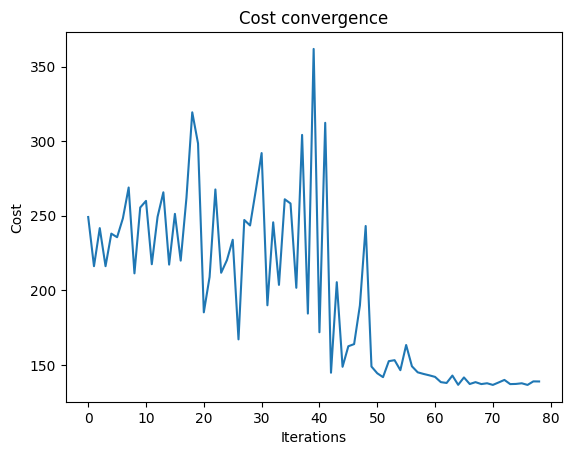

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(cost_values)
axes.set_xlabel("Iterations")
axes.set_ylabel("Cost")
axes.set_title("Cost convergence")

# Optimization Results

We can also examine the statistics of the algorithm. The optimization is always defined as a minimzation problem, so the positive maximization objective was tranlated to a negative minimization one by the pyomo to qmod translator.

In order to get samples with the optimized parameters, we call the `get_results` method:

In [10]:
optimization_result = combi.get_results()
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
151,"{'x_0': 0, 'x_1': 0, 'x_2': 1}",0.001953,-3.000000e+00
178,"{'x_0': 0, 'x_1': 1, 'x_2': 0}",0.000977,-2.000000e+00
11,"{'x_0': 1, 'x_1': 0, 'x_2': 0}",0.014648,-1.000000e+00
4,"{'x_0': 0, 'x_1': 0, 'x_2': 0}",0.020020,1.527468e-150
68,"{'x_0': 0, 'x_1': 0, 'x_2': 1}",0.004395,7.000000e+00


And the histogram:

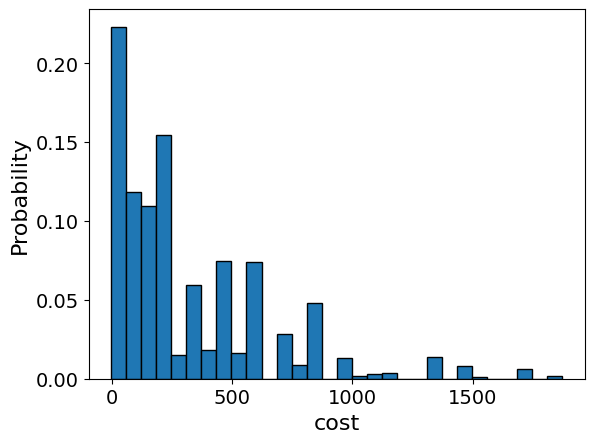

In [11]:
optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x_0': 0, 'x_1': 0, 'x_2': 1}

## Comparison to a classical solver

Lastly, we can compare to the classical solution of the problem:

In [13]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(ilp_model)
classical_solution = [int(pyo.value(ilp_model.x[i])) for i in range(len(ilp_model.x))]
print("Classical solution:", classical_solution)

Classical solution: [0, 0, 1]



## References

<a id='MVC'>[1]</a>: [Integer Programming (Wikipedia).](https://en.wikipedia.org/wiki/Integer_programming)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
